## data loader

In [1]:
from graphlstm_vae_ad import GraphLSTM_VAE_AD
import pandas as pd
import numpy as np

process = "lu.C.16"
process2 = "lu.C.16_inject_cpuocp"
duration = "100ms_closed"

DATASET = "/home/sx/MPI_profile/"+ process + "/" + duration + "/node_feature.csv"
TOPOLOGY = "/home/sx/MPI_profile/"+ process + "/" + duration + "/graph_edge"

DATASET2 = "/home/sx/MPI_profile/"+ process2 + "/" + duration + "/node_feature.csv"
# TOPOLOGY = "/home/sx/MPI_profile/"+ process + "/" + duration + "/graph_edge"


def data_load(filename): 
    data = pd.read_csv(filename, header=[0,1])
    data.columns.names = ['metric', 'host']
    tempm = data.stack()
    tempm = (tempm-tempm.mean())/(tempm.std())
    metric = tempm.unstack().swaplevel('metric','host',axis=1).stack().unstack()


    edge_data = pd.read_csv(TOPOLOGY, header=0)
    # edge_data = edge_data.groupby(['ts_id','src', 'dst']).agg({'commsize': 'sum'}).reset_index()
    edge_data = edge_data.groupby(['src', 'dst']).agg({'commsize': 'sum'}).reset_index()

    edge_index = edge_data[['src', 'dst']].values.T.tolist()
    edge_weight = edge_data['commsize'].values.tolist()

    # print("metric:")
    # print(metric)

    print("Edge Index:")
    print(edge_index)

    # print("Edge Weight:")
    # print(edge_weight)

    return metric, edge_index


metric, edge_index = data_load(DATASET)
metric2, edge_index = data_load(DATASET2)

Edge Index:
[[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15], [1, 4, 0, 2, 5, 1, 3, 6, 2, 7, 0, 5, 8, 1, 4, 6, 9, 2, 5, 7, 10, 3, 6, 11, 4, 9, 12, 5, 8, 10, 13, 6, 9, 11, 14, 7, 10, 15, 8, 13, 9, 12, 14, 10, 13, 15, 11, 14]]


## 加载数据与模型

In [2]:
print(len(metric))

1973


In [2]:
# model = GraphLSTM_VAE_AD(sequence_length=120, gpu=1)
# process = "lulesh_27_ori"
model = GraphLSTM_VAE_AD(name=process + "_" + duration, gpu=0, sequence_length=30, hidden_dim=8, batch_size=32, lr=1e-3, num_epochs=2000)

## 训练模型

Epoch [280/2000], Iter [40/42], total_loss: -928.1338
valid_loss: [13634.662814670139, 13207.584147135416, 12640.133517795139, 12005.068684895834, 11152.945855034723, 10366.925889756945, 9629.716200086805, 9204.021809895834, 9034.297417534723, 8957.86537000868, 8823.190483940973, 9087.766031901041, 7750.3818359375, 7459.901394314236, 7126.509711371527, 6990.432915581598, 6810.301188151042, 6586.500434027777, 6571.471028645833, 6236.72509765625, 6122.974826388889, 6385.617133246527, 5634.173665364583, 5450.203152126736, 5386.099880642361, 5201.262234157986, 4982.09612358941, 4973.133083767361, 4807.800048828125, 5216.598795572917, 4538.899848090277, 4353.310112847223, 4252.263997395833, 4193.536716037326, 4437.377685546875, 4203.9571533203125, 3921.2359754774307, 4118.4521484375, 4235.525078667535, 3777.4747856987847, 3763.539849175347, 3489.3272840711807, 3384.790974934896, 3514.2164306640625, 3271.9590996636284, 3260.357408311632, 3084.248033311632, 3467.2955457899307, 4165.7553168402

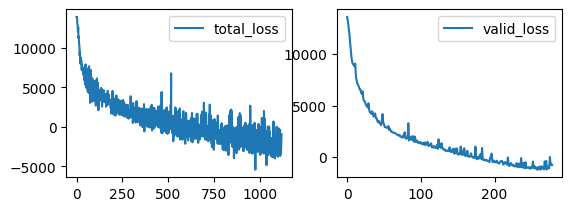

100%|██████████| 18/18 [00:12<00:00,  1.48it/s]


In [4]:
model.fit(metric, 27, edge_index, log_step=10, patience=20)

In [39]:
model.load(27, metric.shape[1])

In [40]:
scores_sum = []
scores_max = []
scores = []
outputs = []
scores, scores_sum, scores_max, outputs = model.predict(metric, 27, edge_index, 1)

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

304
(30,)
304
(30, 27)


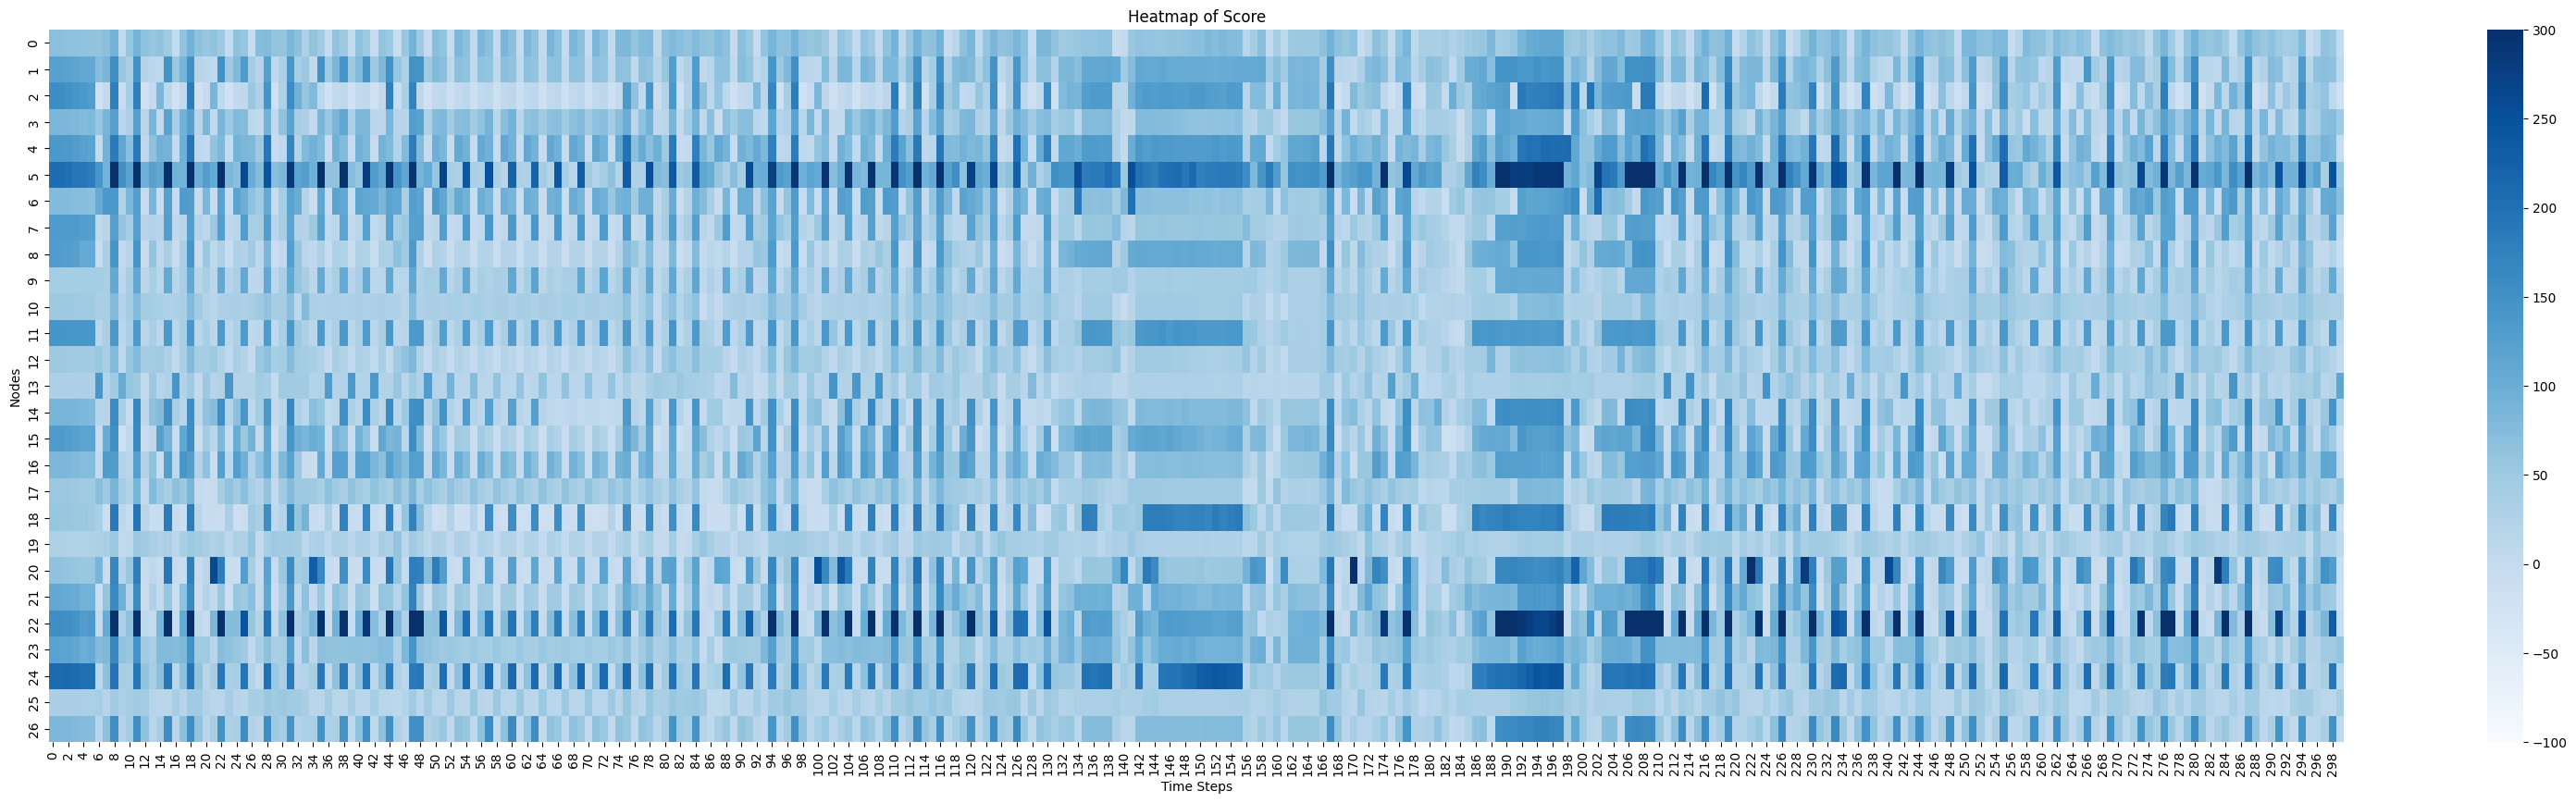

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 scores_sum 是形状为 (699, 16) 的数组
# scores_sum = np.random.rand(699, 16)
scores = scores.T
scores = scores[:, :300]
# 设置绘图尺寸
plt.figure(figsize=(40, 10))

# 使用 seaborn 绘制热力图
sns.heatmap(scores, cmap='Blues', cbar=True, vmin=-100, vmax=300)

# 设置标题和标签
plt.title('Heatmap of Score')
plt.xlabel('Time Steps')
plt.ylabel('Nodes')

# 显示热力图
plt.show()

In [26]:
mylog = open('output.txt', mode = 'a',encoding='utf-8')
for i in range(len(outputs)):
    print(outputs[i], file=mylog)
mylog.close()
# df_outputs = pd.DataFrame(data=outputs)
# df_outputs.to_csv('outputs.csv')
# print(outputs)

In [28]:
mylog = open('scores_max.txt', mode = 'a',encoding='utf-8')
for i in range(len(scores_max)):
    print(scores_max[i], file=mylog)
mylog.close()